# Random Forest Model

In [33]:
# Custom Functions
from Credit_Func import *

# Import the Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# Other
import pickle

# Model
from sklearn.ensemble import RandomForestClassifier

# Sklearn
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [37]:
def plot_confusion_matix(y_val, y_pred, classes):
    import itertools
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print('\n clasification report:\n', classification_report(y_val,y_pred))
    print("-----------------------------------------------")
    print(f"Accuracy: {round(accuracy*100,3)}%")
    print(f"Precision: {round(precision*100,3)}%")
    print(f"Recall: {round(recall*100,3)}%")
    print(f"f1_score: {round(f1*100,3)}%")

    cnf_matrix = confusion_matrix(y_val, y_pred)
    print(f"Frauds: {y_val.sum()} | Missed: {round((cnf_matrix[1][0]/y_val.sum())*100,1)}%")
    
    # Create the basic matrix
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

    # Add title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Add appropriate axis scales
    class_names = ['',classes[0],'',classes[1],'']# set(y) # Get class labels to add to matrix
    tick_marks = [-0.5,0,0.5,1,1.5]
    
    # Add appropriate axis scales
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add labels to each cell
    thresh = cnf_matrix.max() / 2. # Used for text coloring below
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment='center',
                     color='white' if cnf_matrix[i, j] > thresh else 'black')

In [63]:
def roc_plot(model,X_train,y_train,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(7,7))
    for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

In [4]:
df = pd.read_csv('creditcard.csv')

In [5]:
time = df['Time']
new_time = []
for d in time:
    if d <= 86400:     # There are 86400 seconds in a day
        new_time.append(d)
    else:
        new_time.append(d - 86400)
        
df['Time'] = new_time      

In [6]:
y = df.Class

X = df.drop(columns=['Class'], axis=1)

# TTS

In [7]:
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Data Shapes:")
print(f"X_tv: {X_tv.shape} | X_test: {X_test.shape} | y_tv {y_tv.shape} | y_test {y_test.shape}")
print(f"Number of Frauds in TV: {y_tv.sum()} | {round((y_tv.sum() / y_tv.shape[0])*100, 5)}%")
print(f"Number of Frauds in Test: {y_test.sum()} | {round((y_test.sum() / y_test.shape[0])*100, 5)}%")

Data Shapes:
X_tv: (199364, 30) | X_test: (85443, 30) | y_tv (199364,) | y_test (85443,)
Number of Frauds in TV: 356 | 0.17857%
Number of Frauds in Test: 136 | 0.15917%


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.3, random_state=42)

print(f"X_train: {X_train.shape} | X_val: {X_val.shape} | y_train {y_train.shape} | y_val {y_val.shape}")
print(f"Number of Frauds in Train: {y_train.sum()} | {round((y_train.sum() / y_train.shape[0])*100, 5)}%")
print(f"Number of Frauds in Validation: {y_val.sum()} | {round((y_val.sum() / y_val.shape[0])*100, 5)}%")

X_train: (139554, 30) | X_val: (59810, 30) | y_train (139554,) | y_val (59810,)
Number of Frauds in Train: 258 | 0.18487%
Number of Frauds in Validation: 98 | 0.16385%


# Scaling - NOT RF

In [9]:
# scaler = StandardScaler()
# X_train_transformed = scaler.fit_transform(X_train)
# X_Val_transformed = scaler.transform(X_val)
# X_test_transformed = scaler.transform(X_test)
# trans = [X_train_transformed, X_Val_transformed, X_test_transformed]

# for X in trans:
#     print(("mean: "), np.round(X.mean(), 2))
#     print(("standard dev: "), np.round(X.std(), 2))

In [10]:
# # Reset data
# X_train = X_train_transformed
# X_val = X_Val_transformed
# X_test = X_test_transformed

# Sampling 

In [11]:
from imblearn.over_sampling import SMOTE, ADASYN

## SMOTE

In [12]:
# Previous original class distribution
print("original class distribution:")
print(y_train.value_counts())

# Fit SMOTE to training data
smote = SMOTE(sampling_strategy='auto') # resample all classes but the majority class
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print("SMOTE_even class distribution")
print(pd.Series(y_train_smote).value_counts()) 

original class distribution:
0    139296
1       258
Name: Class, dtype: int64


SMOTE_even class distribution
1    139296
0    139296
Name: Class, dtype: int64


## ADASYN

In [13]:
# # Previous original class distribution
# print("original class distribution:")
# print(y_train.value_counts())

# # Fit SMOTE to training data
# adasyn = ADASYN(sampling_strategy='auto') # resample all classes but the majority class
# X_train_adasyn, y_train_adasyn = adasyn.fit_sample(X_train, y_train) 

# # Preview synthetic sample class distribution
# print('\n')
# print("ADASYN class distribution")
# print(pd.Series(y_train_adasyn).value_counts()) 

# Random Forest Model

In [14]:
# Construct pipeline
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state = 123))])

In [15]:
pipe_rf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'clf', 'clf__bootstrap', 'clf__ccp_alpha', 'clf__class_weight', 'clf__criterion', 'clf__max_depth', 'clf__max_features', 'clf__max_leaf_nodes', 'clf__max_samples', 'clf__min_impurity_decrease', 'clf__min_impurity_split', 'clf__min_samples_leaf', 'clf__min_samples_split', 'clf__min_weight_fraction_leaf', 'clf__n_estimators', 'clf__n_jobs', 'clf__oob_score', 'clf__random_state', 'clf__verbose', 'clf__warm_start'])

In [16]:
# Set grid search params
param_grid_forest = [ 
  {'clf__max_depth': [3, 4, 5, 6, 7],  
   'clf__min_samples_leaf':[0.01, 0.05 ,0.1, 0.15, 0.2],  
  }]

In [17]:
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='roc_auc',
            cv=5, verbose=1, return_train_score = True,  n_jobs=1)

# Fit Model to training data
gs_rf.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 53.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                              

In [18]:
from joblib import dump, load
dump(gs_rf, 'randf_model_final.joblib') 

['randf_model_final.joblib']

In [42]:
opt_rf = GS_Output_DataFrame(gs_rf)
opt_rf.sort_values(by='mean_test_score', ascending=False).head()

,clf__max_depth,clf__min_samples_leaf,mean_test_score,std_test_score,mean_train_score,std_train_score
20,7,0.01,0.995908,0.000119,0.995974,0.000084
15,6,0.01,0.995480,0.000128,0.995552,0.000028
10,5,0.01,0.994767,0.000179,0.994851,0.000068
5,4,0.01,0.993735,0.000134,0.993798,0.000058
21,7,0.05,0.992851,0.000073,0.992879,0.000104


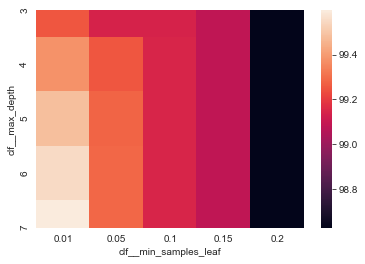

In [27]:
sns.heatmap(pd.pivot_table(opt_rf,index='clf__max_depth',
                           columns='clf__min_samples_leaf',
                           values='mean_train_score')*100)

In [28]:
best_model = gs_rf.best_estimator_
print(gs_rf.best_params_)

{'clf__max_depth': 7, 'clf__min_samples_leaf': 0.01}


In [29]:
y_pred = best_model.predict(X_val)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
y_prob = best_model.predict_proba(X_val)
y_prob

array([[0.98274221, 0.01725779],
       [0.99433004, 0.00566996],
       [0.9768217 , 0.0231783 ],
       ...,
       [0.98600388, 0.01399612],
       [0.961614  , 0.038386  ],
       [0.81020821, 0.18979179]])


 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     59712
           1       0.11      0.85      0.20        98

    accuracy                           0.99     59810
   macro avg       0.56      0.92      0.60     59810
weighted avg       1.00      0.99      0.99     59810

-----------------------------------------------
Accuracy: 98.885%
Precision: 11.293%
Recall: 84.694%
f1_score: 19.928%
Frauds: 98 | Missed: 15.3%


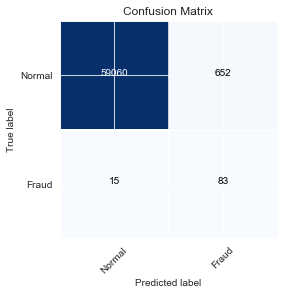

In [38]:
plot_confusion_matix(y_val, y_pred, ['Normal', "Fraud"])

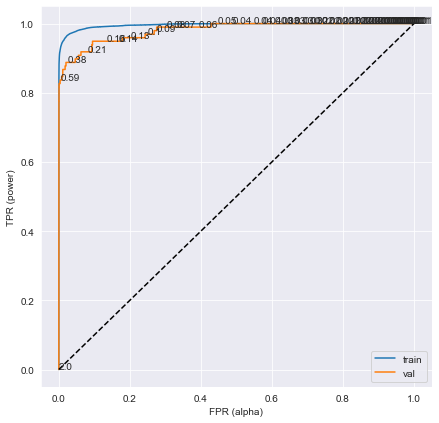

In [64]:
roc_plot(best_model, X_train_smote, y_train_smote, X_val, y_val)

# RF Model 2

In [44]:
# Set grid search params
param_grid_forest_2 = [ 
  {'clf__max_depth': [7, 8, 9, 10, 11],  
   'clf__min_samples_leaf':[0.0001, 0.0005, 0.001, 0.005 ,0.01],  
  }]

In [45]:
gs_rf_2 = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest_2,
            scoring='roc_auc',
            cv=5, verbose=1, return_train_score = True,  n_jobs=1)

# Fit Model to training data
gs_rf_2.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 151.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                              

In [46]:
from joblib import dump, load
dump(gs_rf_2, 'randf_model_final.joblib') 

['randf_model_final.joblib']

In [47]:
opt_rf_2 = GS_Output_DataFrame(gs_rf_2)
opt_rf_2.sort_values(by='mean_test_score', ascending=False).head()

,clf__max_depth,clf__min_samples_leaf,mean_test_score,std_test_score,mean_train_score,std_train_score
20,11,0.0001,0.999920,0.000017,0.999946,0.000006
15,10,0.0001,0.999857,0.000034,0.999894,0.000009
21,11,0.0005,0.999766,0.000042,0.999810,0.000008
10,9,0.0001,0.999713,0.000053,0.999765,0.000018
16,10,0.0005,0.999674,0.000053,0.999719,0.000021


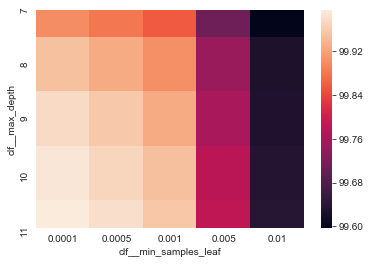

In [76]:
sns.heatmap(pd.pivot_table(opt_rf_2,index='clf__max_depth',
                           columns='clf__min_samples_leaf',
                           values='mean_train_score')*100)

In [49]:
best_model_2 = gs_rf.best_estimator_
print(gs_rf.best_params_)

{'clf__max_depth': 7, 'clf__min_samples_leaf': 0.01}


In [50]:
y_pred_2 = best_model.predict(X_val)
y_pred_2

array([0, 0, 0, ..., 0, 0, 0])

In [51]:
y_prob_2 = best_model.predict_proba(X_val)
y_prob_2

array([[0.98274221, 0.01725779],
       [0.99433004, 0.00566996],
       [0.9768217 , 0.0231783 ],
       ...,
       [0.98600388, 0.01399612],
       [0.961614  , 0.038386  ],
       [0.81020821, 0.18979179]])


 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     59712
           1       0.11      0.85      0.20        98

    accuracy                           0.99     59810
   macro avg       0.56      0.92      0.60     59810
weighted avg       1.00      0.99      0.99     59810

-----------------------------------------------
Accuracy: 98.885%
Precision: 11.293%
Recall: 84.694%
f1_score: 19.928%
Frauds: 98 | Missed: 15.3%


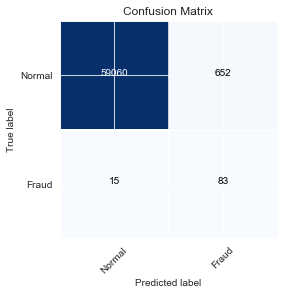

In [52]:
plot_confusion_matix(y_val, y_pred_2, ['Normal', "Fraud"])

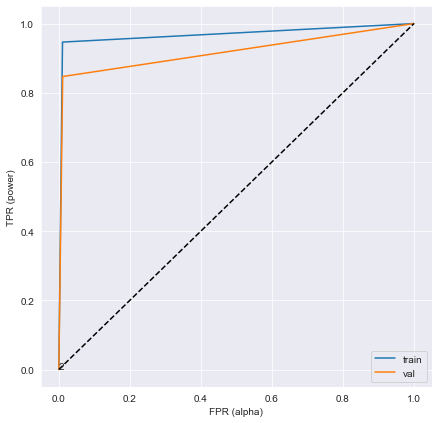

In [54]:
roc_plot(best_model_2, X_train_smote, y_train_smote, X_val, y_val)

## Threshold Selection

In [58]:
prevalence = df['Class'].sum()/df.shape[0]
fraud_cost_coef = 122.21132113821139
normal_cost_coef = 88.29102242231328

In [59]:
def threshold_selection_mark(prevalence, CostFP_minus_CostTN, CostFN_minus_CostTP, y, y_hat):
    """Calculate the optimal treshold depending on prevalence, costs, true positive rate and false positive rate
    Args:
        prevalence (float): The percentage of positives in the population
        CostFP_minus_CostTN (float): [description]
        CostFN_minus_CostTP (float): [description]
        y (list): True labels (classes)
        y_hat (list): Predicted labels (classes)
    Returns:
        [float]: Best threshold
    """
    fpr, tpr, thresholds = roc_curve(y, y_hat)
    m = ((1 - prevalence) / prevalence) * ((CostFP_minus_CostTN) / (CostFN_minus_CostTP))
    fm_thresholds = []
    for i in range(len(fpr)):
        fm = tpr[i] - (m * fpr[i])
        fm_thresholds.append((thresholds[i], fm, fpr[i], tpr[i]))
#     fm_thresholds_df = pd.DataFrame(data=fm_thresholds, columns=['Threshold', 'fm', 'FPR', 'TPR'])
#     fm_thresholds_df.sort_values(by='fm', inplace=True, ascending=False)
    fm_thresholds = sorted(fm_thresholds, key=lambda fm_value: fm_value[1], reverse=True)
#     return fm_thresholds_df
    return fm_thresholds[0][0]

In [62]:
threshold_selection_mark(prevalence, fraud_cost_coef, normal_cost_coef, y_val, y_prob_2[:,1])

0.9214728295666995

## Feature Importance

In [68]:
dir(best_model)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_estimator_type',
 '_final_estimator',
 '_fit',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_inverse_transform',
 '_iter',
 '_log_message',
 '_more_tags',
 '_pairwise',
 '_replace_estimator',
 '_required_parameters',
 '_set_params',
 '_transform',
 '_validate_names',
 '_validate_steps',
 'classes_',
 'decision_function',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_params',
 'inverse_transform',
 'memory',
 'named_steps',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'score',
 'score_samples',
 'set_para

In [65]:
features = pd.DataFrame(best_model.feature_importances_, index=[X_tv.columns], columns=['Importance'])
features = features.loc[features['Importance'] != 0]
# features

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

In [66]:
def plot_feature_importances(model, X):
    n_features = X.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance SVM', fontsize=18)

plot_feature_importances(best_model, X_tv)

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

<Figure size 576x576 with 0 Axes>

## Tree Viz

In [75]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(best_model_2, 
                out_file='RF.dot', 
                rounded = True, proportion = False, 
                precision = 2, filled = True)

NotFittedError: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.